# 2. Topic modelling

## Setup

In [1]:
%run __init__.py

In [2]:
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [3]:
from herc_common.utils import save_object

In [4]:
RANDOM_SEED=42

## Loading the dataframe

In [5]:
GIT_FILE_PATH = os.path.join(NOTEBOOK_1_RESULTS_DIR, 'git_dataframe.pkl')

git_df = pd.read_pickle(GIT_FILE_PATH)

## Preprocessing text

In [6]:
git_repositories = git_df['full_text_cleaned'].values

In [7]:
import en_core_sci_lg

from herc_common.text import TextPreprocessor


custom_stop_words = {"merge", "branch", "master", "refs", "svn",
                     "branch", "pull", "request", "fix", "ref",
                     "error", "add", "file", "bug", "class", "return",
                     "string", "test", "case", "run", "install", "object",
                     "readme"}

git_preprocessor = TextPreprocessor(en_core_sci_lg, custom_stop_words)
preprocessed_texts = git_preprocessor.fit_transform(git_repositories)

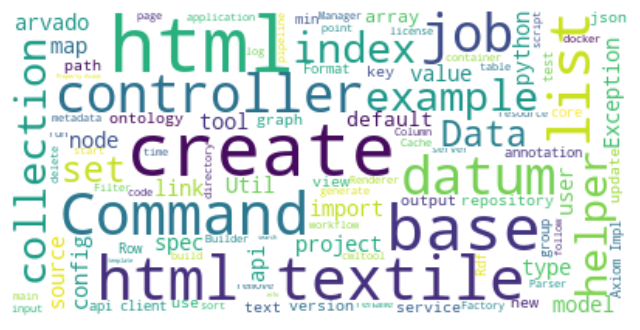

In [8]:
from herc_common.text import plot_word_cloud

complete_text = ' '.join([' '.join(token) for token in preprocessed_texts])

plot_word_cloud(complete_text)

## LDA

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc


tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
dtm_tf = tf_vectorizer.fit_transform(preprocessed_texts)

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

from herc_common.topic_modeling import base_scoring_function, compute_model_results


lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tf_vectorizer,
                                        texts=preprocessed_texts, model=clf, X=X,
                                        top_n=5)


lda_results = compute_model_results(LatentDirichletAllocation, dtm_tf,
                                    lda_scoring_func, seed=RANDOM_SEED,
                                    min_topics=15, max_topics=70, max_iter=100)
lda_results

c:\users\alex\.envs\edma\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


{LatentDirichletAllocation(max_iter=100, n_components=15, random_state=42): -2.933418636810475,
 LatentDirichletAllocation(max_iter=100, n_components=16, random_state=42): -6.130878604351114,
 LatentDirichletAllocation(max_iter=100, n_components=17, random_state=42): -4.431666339683361,
 LatentDirichletAllocation(max_iter=100, n_components=18, random_state=42): -4.189046471807331,
 LatentDirichletAllocation(max_iter=100, n_components=19, random_state=42): -5.258273022662132,
 LatentDirichletAllocation(max_iter=100, n_components=20, random_state=42): -5.154264931096949,
 LatentDirichletAllocation(max_iter=100, n_components=21, random_state=42): -4.287522142321605,
 LatentDirichletAllocation(max_iter=100, n_components=22, random_state=42): -5.256866775643564,
 LatentDirichletAllocation(max_iter=100, n_components=23, random_state=42): -4.569066039829946,
 LatentDirichletAllocation(max_iter=100, n_components=24, random_state=42): -4.036358827681176,
 LatentDirichletAllocation(max_iter=100,

In [11]:
from herc_common.topic_modeling import get_best_model, print_results_info

print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

Best model parameters: {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 100, 'mean_change_tol': 0.001, 'n_components': 15, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
Topic coherence: -2.933418636810475


In [12]:
from herc_common.topic_modeling import print_top_words

tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 10)

Topic #0: html job tool cwltool bill spec create package workflow document
Topic #1: virtualenv tool uploader use sentence sequence table enter enter virtualenv npuserstudy
Topic #2: concept format example check tbox model abox subsumption expansion aspnetcoreapp
Topic #3: stability quality datum music quality quality obo stability stability model agro datum datum
Topic #4: Axiom Property Impl Factory Data Builder Format OWLOntology ontology annotation
Topic #5: html textile html textile controller job helper collection create user container
Topic #6: cleanup virtuoso quote Best temp main material Parse Plotly stuff
Topic #7: base Command array create log core property Index source prov
Topic #8: Data Learning Cheat Python Sheet Cheat Sheet Machine Machine Learning Science Data Science
Topic #9: graph main odgi node sort path version build optimize dynamic
Topic #10: codon jetty find Data position Kefed system codon find transcript small
Topic #11: trackhub pipeline application termite

In [13]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7      114.344879  114.308296       1        1  22.116636
5      105.821045  -93.749626       2        1  16.500442
4     -138.334473   95.320763       3        1  15.356803
12      -7.436697  111.259697       4        1  10.801283
0     -207.550629 -105.472603       5        1  10.452891
10      52.817650   14.603765       6        1   4.597942
13     168.010849    6.806950       7        1   4.413714
3      -94.169601 -157.789551       8        1   3.524883
11    -122.849174  -39.059418       9        1   3.357395
8      -94.894264  195.408295      10        1   3.037048
2       24.927401 -180.464874      11        1   2.660361
9      -53.413467   26.832108      12        1   1.757890
1      -12.255850  -72.093201      13        1   1.413718
14    -224.217957   28.070581      14        1   0.004497
6       36.154255  209.427582      15        1   0.004497, topic_info=               Term        Freq       Total Category  logprob  loglift
20246          html  362.000000  362.000000  Default  30.0000  30.0000
555           Axiom  159.000000  159.000000  Default  29.0000  29.0000
7300       Property  166.000000  166.000000  Default  28.0000  28.0000
32755       textile  128.000000  128.000000  Default  27.0000  27.0000
20400  html textile  127.000000  127.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
13749         cmake    0.000093    7.000243  Topic15 -10.4805  -1.2174
26550          play    0.000093    2.521588  Topic15 -10.4805  -0.1963
14931    conversion    0.000093    3.447447  Topic15 -10.4805  -0.5090
3443          Field    0.000093    3.647773  Topic15 -10.4805  -0.5655
11501           arg    0.000093    5.406920  Topic15 -10.4805  -0.9591

[1206 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
2         13  0.572639            AIDA
4         13  0.694007   AIDA sentence
5         11  0.856699            ALCQ
221        8  0.956041        Anaconda
227        8  0.224919        Analysis
...      ...       ...             ...
35412      8  0.956041  xgb classifier
35521     12  0.811917           yeast
35574      4  0.187097            zero
35574      7  0.748388            zero
35575      7  1.001023     zero config

[1807 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 5, 13, 1, 11, 14, 4, 12, 9, 3, 10, 2, 15, 7])

In [15]:
from sklearn.pipeline import Pipeline

lda_pipeline = Pipeline([('preprocessing', git_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lda_model)])

lda_git_pipe_filename = "git_lda_model.pkl"
save_object(lda_pipeline, os.path.join(NOTEBOOK_2_RESULTS_DIR, lda_git_pipe_filename))

In [16]:
dtm_tf_filename = "git_dtm_tf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_2_RESULTS_DIR, dtm_tf_filename))

# LSA

In [17]:
from sklearn.decomposition import TruncatedSVD

lsa_scoring_func = lda_scoring_func

lsa_results = compute_model_results(TruncatedSVD, dtm_tf, lsa_scoring_func, 
                                    seed=RANDOM_SEED, min_topics=15,
                                    max_topics=70)
lsa_results

{TruncatedSVD(n_components=15, random_state=42): -2.73471442777813,
 TruncatedSVD(n_components=16, random_state=42): -2.630174575037056,
 TruncatedSVD(n_components=17, random_state=42): -2.499782932718802,
 TruncatedSVD(n_components=18, random_state=42): -2.8956965853612098,
 TruncatedSVD(n_components=19, random_state=42): -2.772210143123272,
 TruncatedSVD(n_components=20, random_state=42): -2.6974890477453335,
 TruncatedSVD(n_components=21, random_state=42): -2.611449956637389,
 TruncatedSVD(n_components=22, random_state=42): -2.85061763799214,
 TruncatedSVD(n_components=23, random_state=42): -2.772638650188974,
 TruncatedSVD(n_components=24, random_state=42): -2.8951383247293685,
 TruncatedSVD(n_components=25, random_state=42): -2.8008339053689304,
 TruncatedSVD(n_components=26, random_state=42): -2.7206750546870953,
 TruncatedSVD(n_components=27, random_state=42): -2.648933269441557,
 TruncatedSVD(n_components=28, random_state=42): -2.579083766265428,
 TruncatedSVD(n_components=29, 

In [18]:
print_results_info(lsa_results)
best_lsa_model = get_best_model(lsa_results)

Best model parameters: {'algorithm': 'randomized', 'n_components': 50, 'n_iter': 5, 'random_state': 42, 'tol': 0.0}
Topic coherence: -1.900272341775915


In [19]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lsa_model, tf_feature_names, 10)

Topic #0: html textile html textile job collection create controller user api container
Topic #1: Axiom Property Impl Factory Data Builder Format OWLOntology ontology Visitor
Topic #2: base Command array create core Index source map min Operation
Topic #3: job tool cwltool package workflow output CWL cwl plugin command
Topic #4: spec bill datum jquery gifs animate gifs animate html page colorbox
Topic #5: datum gifs animate gifs animate colorbox jquery colorbox textile html textile colorbox jquery jquery
Topic #6: Data Connection Exception Handler Statement Mysql Category Regression Category Handler Result
Topic #7: log poly poly log feature season point player reduce reduce feature log reduce
Topic #8: Data Learning Cheat Python Sheet Cheat Sheet stability Machine Learning Machine Data Science
Topic #9: stability quality quality quality stability stability obo agro datum datum datum optimal metric
Topic #10: Utils Renderer Property Model spec Elda min Query icon link
Topic #11: codon 

In [20]:
lsa_pipeline = Pipeline([('preprocessing', git_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lsa_model)])

lsa_git_pipe_filename = "git_lsa_model.pkl"
save_object(lsa_pipeline, os.path.join(NOTEBOOK_2_RESULTS_DIR, lsa_git_pipe_filename))

## NMF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
dtm_tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)

In [22]:
from sklearn.decomposition import NMF

nmf_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tfidf_vectorizer,
                                                        texts=preprocessed_texts, model=clf, X=X)

nmf_results = compute_model_results(NMF, dtm_tfidf, nmf_scoring_func, 
                                    seed=RANDOM_SEED, min_topics=5,
                                    max_topics=70, max_iter=1000)
nmf_results

{NMF(max_iter=1000, n_components=5, random_state=42): -4.9279282977239145,
 NMF(max_iter=1000, n_components=6, random_state=42): -4.475171084483707,
 NMF(max_iter=1000, n_components=7, random_state=42): -4.476033295134199,
 NMF(max_iter=1000, n_components=8, random_state=42): -5.158464318577359,
 NMF(max_iter=1000, n_components=9, random_state=42): -7.075630817941268,
 NMF(max_iter=1000, n_components=10, random_state=42): -6.92902361584729,
 NMF(max_iter=1000, n_components=11, random_state=42): -6.480998728142976,
 NMF(max_iter=1000, n_components=12, random_state=42): -7.362209741465171,
 NMF(max_iter=1000, n_components=13, random_state=42): -7.305597086514354,
 NMF(max_iter=1000, n_components=14, random_state=42): -7.2235886375866505,
 NMF(max_iter=1000, n_components=15, random_state=42): -7.590038258493019,
 NMF(max_iter=1000, n_components=16, random_state=42): -7.249915393165594,
 NMF(max_iter=1000, n_components=17, random_state=42): -6.59379959673298,
 NMF(max_iter=1000, n_componen

In [23]:
print_results_info(nmf_results)
best_nmf_model = get_best_model(nmf_results)

Best model parameters: {'alpha': 0.0, 'beta_loss': 'frobenius', 'init': None, 'l1_ratio': 0.0, 'max_iter': 1000, 'n_components': 67, 'random_state': 42, 'shuffle': False, 'solver': 'cd', 'tol': 0.0001, 'verbose': 0}
Topic coherence: -0.5722694074152177


In [24]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(best_nmf_model, tfidf_feature_names, 10)

Topic #0: base array create core Index Operation dialog property map Exporter
Topic #1: Property spec Elda Utils Renderer Query apispec Player min Context
Topic #2: concept tbox subsumption abox format expansion check axiom consistency relationname
Topic #3: Connection Exception Handler Mysql Statement Category Handler Category Regression Fabric Data
Topic #4: mpcc optimize MKL correlation compile version Pearsons correlation Intel MKL optimize version coefficient
Topic #5: encode Huffman Table decode Huffman dna sequence dna compression Table group symbol text contain
Topic #6: figure Crisis Generalizability Crisis Generalizability Yarkoni Generalizability Yarkoni datum code datum wade mammarella mccoy
Topic #7: pogo pogoentry import list use library public clusteredpsmreport unique entry
Topic #8: Termite Service Similarity common Service Impl Termite Service api termite Service Similarity Similarity Service httpclient
Topic #9: controller html spec helper project controller spec ren

In [25]:
from sklearn.pipeline import Pipeline

nmf_pipeline = Pipeline([('preprocessing', git_preprocessor),
                         ('vectorizer', tfidf_vectorizer),
                         ('model', best_nmf_model)])

nmf_git_pipe_filename = "git_nmf_model.pkl"
save_object(nmf_pipeline, os.path.join(NOTEBOOK_2_RESULTS_DIR, nmf_git_pipe_filename))

In [26]:
dtm_tfidf_filename = "git_dtm_tfidf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_2_RESULTS_DIR, dtm_tfidf_filename))